# **RETO HACKATON**: *CIENCIA DE DATOS - CAIXA BANK*
*Carlos Cabruja - Data*

## Background

El IBEX 35 es el √≠ndice oficial de la bolsa espa√±ola compuesto por las 35 empresas m√°s negociadas del mercado. Este √≠ndice nos muestra en tiempo real si los precios en bolsa est√°n subiendo o bajando, por lo que permite medir el comportamiento de este conjunto de acciones.

El IBEX35 sirve como punto de referencia para los inversores del mercado espa√±ol. La rentabilidad de este √≠ndice es el objetivo a batir por los gestores.

Por lo tanto, la modelizaci√≥n de las din√°micas de este tipo de √≠ndices resultan esenciales para la toma de decisiones por parte de todas las entidades burs√°tiles.

## Reto

1. Desarrolla un modelo predictivo que permita predecir la variable target (si el precio de cierre del IBEX35 ser√° superior o inferior al precio de cierre actual).

Para ello deberas entrenar tu modelo con los datos de training (si tambi√©n se usan los tweets se sumaran 100 puntos) e introducir como input de tu modelo el dataset test_x para realizar las predicciones.

2. Crea un breve documento (m√°x. 2 p√°ginas) o presentaci√≥n (m√°x. 4 slides) explicando la soluci√≥n que has empleado y porque la has empleado.

## Librer√≠as

In [150]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import nltk
import datetime as dt

# Gr√°ficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuraci√≥n warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Recopilaci√≥n y an√°lisis de datos

In [86]:
# cargamos los datasets a trabajar
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test_x.csv')
tweets = pd.read_csv('data/tweets_from2015_#Ibex35.csv')

In [87]:
train # visualizamos los datos de entrenamiento

Date         Open         High          Low        Close  \
0     1994-01-03  3615.199951  3654.699951  3581.000000  3654.500000   
1     1994-01-04  3654.500000  3675.500000  3625.100098  3630.300049   
2     1994-01-05  3625.199951  3625.199951  3583.399902  3621.199951   
3     1994-01-06          NaN          NaN          NaN          NaN   
4     1994-01-07  3621.199951  3644.399902  3598.699951  3636.399902   
...          ...          ...          ...          ...          ...   
6549  2019-05-24  9150.299805  9211.099609  9141.400391  9174.599609   
6550  2019-05-27  9225.900391  9294.599609  9204.700195  9216.400391   
6551  2019-05-28  9220.400391  9224.900391  9132.900391  9191.799805   
6552  2019-05-29  9113.200195  9116.700195  9035.099609  9080.500000   
6553  2019-05-30  9120.799805  9175.200195  9114.099609  9157.799805   

        Adj Close       Volume  Target  
0     3654.496338          0.0       0  
1     3630.296387          0.0       1  
2     3621.196289          0.0       1  
3             NaN          NaN       0  
4     3636.396240          0.0       1  
...           ...          ...     ...  
6549  9174.599609  121673100.0       0  
6550  9216.400391   60178000.0       0  
6551  9191.799805  218900800.0       0  
6552  9080.500000  148987100.0       0  
6553  9157.799805  101389200.0       0  

[6554 rows x 8 columns]

In [88]:
test # visualizamos los datos de prueba

test_index        Date         Open         High          Low  \
0          6557  2019-06-05  9136.799805  9173.400391  9095.000000   
1          6558  2019-06-06  9169.200195  9246.200195  9136.700195   
2          6559  2019-06-07  9186.700195  9261.400391  9185.700195   
3          6560  2019-06-10  9284.200195  9302.200195  9248.099609   
4          6561  2019-06-11  9288.599609  9332.500000  9273.400391   
..          ...         ...          ...          ...          ...   
721        7278  2022-03-25  8314.099609  8363.200195  8286.500000   
722        7279  2022-03-28  8354.400391  8485.700195  8354.400391   
723        7280  2022-03-29  8451.000000  8621.000000  8419.700195   
724        7281  2022-03-30  8583.299805  8597.400391  8508.900391   
725        7282  2022-03-31  8562.599609  8588.299805  8445.099609   

           Close    Adj Close       Volume  
0    9150.500000  9150.500000  158753000.0  
1    9169.200195  9169.200195  212720900.0  
2    9236.099609  9236.099609  150664700.0  
3    9294.099609  9294.099609  102323700.0  
4    9282.099609  9282.099609  144701200.0  
..           ...          ...          ...  
721  8330.599609  8330.599609  156189000.0  
722  8365.599609  8365.599609  167961800.0  
723  8614.599609  8614.599609  257812200.0  
724  8550.599609  8550.599609  185389000.0  
725  8445.099609  8445.099609  220117500.0  

[726 rows x 8 columns]

In [89]:
tweets # visualizamos los datos de tweets

tweetDate           handle  \
0     Sat Apr 09 14:47:45 +0000 2022         abelac62   
1     Thu Apr 07 19:14:36 +0000 2022    LluisPerarnau   
2     Mon Apr 04 16:48:45 +0000 2022     Pegaso121080   
3     Tue Apr 05 07:23:16 +0000 2022        zonavalue   
4     Thu Mar 31 16:07:43 +0000 2022       EPeconomia   
...                              ...              ...   
9796  Thu Jan 08 16:41:36 +0000 2015   elEconomistaes   
9797  Sat Jan 03 17:20:30 +0000 2015      Roger_bolsa   
9798  Sat Jan 10 19:42:45 +0000 2015  Secretosdebolsa   
9799  Sat Jan 10 21:47:17 +0000 2015      Roger_bolsa   
9800  Mon Jan 05 15:06:49 +0000 2015   elEconomistaes   

                                                   text  
0     He hecho el repaso de todos los componentes de...  
1     Els projectes que han presentat les empreses d...  
2     Por si no lo has visto, o no lo encuentras en ...  
3     üìà #BOLSA: El #Ibex35 abre en üü¢ \n\nüá™üá∏ #Ibex35 ...  
4     El #Ibex35 retrocede un 0,4% en marzo y un 3,0...  
...                                                 ...  
9796  #Cierre | El #Ibex35 sube un 2,26% hasta los 1...  
9797  Un vistazo a los #Bluechips del #Ibex #Ibex35....  
9798  As√≠ comienza la #Bolsa en #2015 Ojo a los sopo...  
9799  An√°lisis del #BancoSantander #Santander #SAN t...  
9800  El #Ibex35 profundiza en su ca√≠da (-2,8%) y pi...  

[9801 rows x 3 columns]

Estan correctamente cargados csv, ahora vamos su tipo y si presentan valores nulos.

In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6554 entries, 0 to 6553
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6554 non-null   object 
 1   Open       6421 non-null   float64
 2   High       6421 non-null   float64
 3   Low        6421 non-null   float64
 4   Close      6421 non-null   float64
 5   Adj Close  6421 non-null   float64
 6   Volume     6421 non-null   float64
 7   Target     6554 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 409.8+ KB


Habr√° que hacer tratamiento de nulls en los datos y convertir la columna **Date** en datetime

In [91]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_index  726 non-null    int64  
 1   Date        726 non-null    object 
 2   Open        726 non-null    float64
 3   High        726 non-null    float64
 4   Low         726 non-null    float64
 5   Close       726 non-null    float64
 6   Adj Close   726 non-null    float64
 7   Volume      726 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 45.5+ KB


Parece ya encontrase limpia y lista para ser procesada.

In [92]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9801 entries, 0 to 9800
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweetDate  9799 non-null   object
 1   handle     9798 non-null   object
 2   text       9797 non-null   object
dtypes: object(3)
memory usage: 229.8+ KB


Hacer **tweetdate** un Date para que pueda hacer merge con nuestro dataframe de train, y tratamiento de nulls

### Limpieza de datos

In [93]:
# cuantos nulls tiene tweets?
tweets.isnull().sum()

tweetDate    2
handle       3
text         4
dtype: int64

In [94]:
# filas con nulls en tweetDate
tweets[tweets.tweetDate.isnull()]

tweetDate handle text
6931       NaN    NaN  NaN
9634       NaN    NaN  NaN

No hay nada, eliminamos....

In [95]:
# eliminar filas con nulls en tweetDate
tweets = tweets.dropna(subset=['tweetDate'])

# filas con nulls en text
tweets[tweets.text.isnull()]

tweetDate        handle text
1070  Mon Mar 08 07:13:57 +0000 2021  pharma_jonpi  NaN
9667        Y Montoro dando ca√±a....           NaN  NaN

Tampoco son relevantes los tweets que no tienen fecha de publicaci√≥n, ni texto de los tweets.

In [96]:
# eliminar todos los nulls
tweets = tweets.dropna()
tweets.isnull().sum()

tweetDate    0
handle       0
text         0
dtype: int64

In [97]:
# convertir Date a datetime YYYY-MM-DD
try:
    tweets['tweetDate'] = pd.to_datetime(tweets['tweetDate'])
except Exception as e:
    print(e)

Unknown string format: #Bolsa #IBEX35 https://t.co/2wBR9k3hHr


Como **tweetdate** est√° contaminada con texto la vamos a tratar fila por fila. 

In [98]:
for i in tweets['tweetDate']:
    lista_i = str(i).split(' ')
    if len(lista_i) != 6: # si no tiene 6 elementos (YYYY-MM-DD HH:MM:SS)
        # eliminar filas con fechas mal formateadas
        tweets = tweets.drop(tweets[tweets['tweetDate'] == i].index)

In [99]:
# convertir Date a datetime YYYY-MM-DD
tweets['tweetDate'] = pd.to_datetime(tweets['tweetDate'])

In [100]:
# renombrar tweetDate a Date
tweets = tweets.rename(columns={'tweetDate': 'Date'})

Y la columna handle no nos sirve ya que no daremos importancia a qui√©n ha escrito el tweet.

In [101]:
# eliminar handle de los tweets
tweets = tweets.drop(['handle'], axis=1)
tweets

Date  \
0    2022-04-09 14:47:45+00:00   
1    2022-04-07 19:14:36+00:00   
2    2022-04-04 16:48:45+00:00   
3    2022-04-05 07:23:16+00:00   
4    2022-03-31 16:07:43+00:00   
...                        ...   
9796 2015-01-08 16:41:36+00:00   
9797 2015-01-03 17:20:30+00:00   
9798 2015-01-10 19:42:45+00:00   
9799 2015-01-10 21:47:17+00:00   
9800 2015-01-05 15:06:49+00:00   

                                                   text  
0     He hecho el repaso de todos los componentes de...  
1     Els projectes que han presentat les empreses d...  
2     Por si no lo has visto, o no lo encuentras en ...  
3     üìà #BOLSA: El #Ibex35 abre en üü¢ \n\nüá™üá∏ #Ibex35 ...  
4     El #Ibex35 retrocede un 0,4% en marzo y un 3,0...  
...                                                 ...  
9796  #Cierre | El #Ibex35 sube un 2,26% hasta los 1...  
9797  Un vistazo a los #Bluechips del #Ibex #Ibex35....  
9798  As√≠ comienza la #Bolsa en #2015 Ojo a los sopo...  
9799  An√°lisis del #BancoSantander #Santander #SAN t...  
9800  El #Ibex35 profundiza en su ca√≠da (-2,8%) y pi...  

[9793 rows x 2 columns]

Ahora creamos la columna sentimiento, con la libreria de Sentiment Analysis de NLTK.

**An√°lisis de sentimiento VADER:**
VADER (Valence Aware Dictionary and sEntiment Reasoner) es una herramienta de an√°lisis de sentimientos basada en reglas y l√©xico que est√° espec√≠ficamente en sinton√≠a con los sentimientos expresados ‚Äã‚Äãen las redes sociales. VADER usa una combinaci√≥n de un l√©xico de sentimientos es una lista de caracter√≠sticas l√©xicas (por ejemplo, palabras) que generalmente se etiquetan seg√∫n su orientaci√≥n sem√°ntica como positivas o negativas. VADER no solo informa sobre la puntuaci√≥n de positividad y negatividad, sino que tambi√©n nos informa sobre qu√© tan positivo o negativo es un sentimiento.

In [102]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer() # instanciamos el analizador

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [103]:
tweets['sentiment'] = tweets['text'].apply(lambda x: sentiment.polarity_scores(x)['compound'])
tweets

Date  \
0    2022-04-09 14:47:45+00:00   
1    2022-04-07 19:14:36+00:00   
2    2022-04-04 16:48:45+00:00   
3    2022-04-05 07:23:16+00:00   
4    2022-03-31 16:07:43+00:00   
...                        ...   
9796 2015-01-08 16:41:36+00:00   
9797 2015-01-03 17:20:30+00:00   
9798 2015-01-10 19:42:45+00:00   
9799 2015-01-10 21:47:17+00:00   
9800 2015-01-05 15:06:49+00:00   

                                                   text  sentiment  
0     He hecho el repaso de todos los componentes de...     0.0000  
1     Els projectes que han presentat les empreses d...     0.0000  
2     Por si no lo has visto, o no lo encuentras en ...    -0.5267  
3     üìà #BOLSA: El #Ibex35 abre en üü¢ \n\nüá™üá∏ #Ibex35 ...     0.0000  
4     El #Ibex35 retrocede un 0,4% en marzo y un 3,0...     0.0000  
...                                                 ...        ...  
9796  #Cierre | El #Ibex35 sube un 2,26% hasta los 1...     0.0000  
9797  Un vistazo a los #Bluechips del #Ibex #Ibex35....     0.0000  
9798  As√≠ comienza la #Bolsa en #2015 Ojo a los sopo...     0.0000  
9799  An√°lisis del #BancoSantander #Santander #SAN t...     0.0000  
9800  El #Ibex35 profundiza en su ca√≠da (-2,8%) y pi...     0.0000  

[9793 rows x 3 columns]

In [104]:
# eliminar text
tweets = tweets.drop(['text'], axis=1)

Ahora, a fin de hacer el merge con train, trataremos los datos para que sea solo una fecha.

Para los tweets hechos en una misma fecha pero distinta hora, se har√° una media de los sentimientos.

In [105]:
# convertir Date a datetime YYYY-MM-DD
tweets['Date'] = pd.to_datetime(tweets['Date']).dt.date

In [106]:
# eliminar Dates repetidos con el mismo sentimiento y fecha
tweets = tweets.drop_duplicates()

# hay alguna fecha repetida con distinto sentimiento?
tweets.groupby(['Date', 'sentiment']).count()

Empty DataFrame
Columns: []
Index: [(2015-01-03, 0.0), (2015-01-04, 0.0), (2015-01-05, -0.5267), (2015-01-05, 0.0), (2015-01-06, -0.743), (2015-01-06, 0.0), (2015-01-07, 0.0), (2015-01-08, 0.0), (2015-01-09, 0.0), (2015-01-10, 0.0), (2015-01-11, 0.0), (2015-01-12, -0.296), (2015-01-12, 0.0), (2015-01-14, 0.0), (2015-01-15, -0.7345), (2015-01-16, 0.0), (2015-01-19, 0.0), (2015-01-20, 0.0), (2015-01-21, 0.0), (2015-01-22, 0.0), (2015-01-24, 0.0), (2015-01-25, 0.0), (2015-01-26, 0.0), (2015-01-27, 0.0), (2015-01-28, 0.0), (2015-01-29, 0.0), (2015-01-30, 0.0), (2015-01-31, 0.0), (2015-02-01, 0.0), (2015-02-02, 0.0), (2015-02-03, -0.296), (2015-02-03, 0.0), (2015-02-04, 0.0), (2015-02-05, 0.0), (2015-02-06, 0.0), (2015-02-07, 0.0), (2015-02-09, 0.0), (2015-02-10, 0.0), (2015-02-11, 0.34), (2015-02-12, 0.0), (2015-02-13, 0.0), (2015-02-14, 0.0), (2015-02-17, 0.0), (2015-02-18, -0.296), (2015-02-19, 0.0), (2015-02-20, 0.0), (2015-02-22, 0.0), (2015-02-23, 0.0), (2015-02-25, 0.0), (2015-02-27, -0.296), (2015-02-27, 0.0), (2015-03-01, 0.0), (2015-03-02, -0.296), (2015-03-02, 0.0), (2015-03-03, -0.296), (2015-03-03, 0.0), (2015-03-03, 0.34), (2015-03-04, 0.0), (2015-03-05, -0.6249), (2015-03-05, 0.0), (2015-03-06, 0.0), (2015-03-07, 0.0), (2015-03-08, -0.5574), (2015-03-08, 0.0), (2015-03-09, -0.5574), (2015-03-09, 0.0), (2015-03-09, 0.3612), (2015-03-10, 0.0), (2015-03-11, 0.0), (2015-03-12, 0.0), (2015-03-13, 0.0), (2015-03-14, 0.0), (2015-03-15, -0.296), (2015-03-15, 0.0), (2015-03-16, 0.0), (2015-03-16, 0.2942), (2015-03-18, 0.0), (2015-03-19, 0.0), (2015-03-20, 0.0), (2015-03-20, 0.4003), (2015-03-21, 0.0), (2015-03-22, 0.0), (2015-03-22, 0.0516), (2015-03-23, 0.0), (2015-03-24, 0.0), (2015-03-26, 0.0), (2015-03-26, 0.0772), (2015-03-27, -0.6249), (2015-03-27, 0.0), (2015-03-28, 0.0), (2015-03-29, 0.0), (2015-03-29, 0.2023), (2015-03-30, 0.0), (2015-03-31, 0.0), (2015-03-31, 0.5859), (2015-04-02, 0.0), (2015-04-03, 0.0), (2015-04-04, 0.0), (2015-04-05, 0.0), (2015-04-07, 0.0), ...]

[4483 rows x 0 columns]

In [107]:
# sacamos las fechas repetidas con distinto sentimiento
temp_df = tweets.groupby(['Date']).count()
lista_fechas = temp_df[temp_df['sentiment'] > 1].index

# restamos el indice de sentimiento en las fechas repetidas
for i in lista_fechas:
    # sacamos las filas repetidas
    temp_df = tweets[tweets['Date'] == i]
    # restamos el indice de sentimiento en las fechas repetidas
    sentiment = temp_df['sentiment'].mean()
    # actualizamos el sentimiento en las filas repetidas
    tweets.loc[tweets['Date'] == i, 'sentiment'] = sentiment

In [108]:
# eliminamos las filas repetidas
tweets = tweets.drop_duplicates()

Ya tenemos nuestra tabla tweets limpia, as√≠ que hacemos el merge con train.

In [109]:
# hacer train Date a datetime
train['Date'] = pd.to_datetime(train['Date']).dt.date
train

Date         Open         High          Low        Close  \
0     1994-01-03  3615.199951  3654.699951  3581.000000  3654.500000   
1     1994-01-04  3654.500000  3675.500000  3625.100098  3630.300049   
2     1994-01-05  3625.199951  3625.199951  3583.399902  3621.199951   
3     1994-01-06          NaN          NaN          NaN          NaN   
4     1994-01-07  3621.199951  3644.399902  3598.699951  3636.399902   
...          ...          ...          ...          ...          ...   
6549  2019-05-24  9150.299805  9211.099609  9141.400391  9174.599609   
6550  2019-05-27  9225.900391  9294.599609  9204.700195  9216.400391   
6551  2019-05-28  9220.400391  9224.900391  9132.900391  9191.799805   
6552  2019-05-29  9113.200195  9116.700195  9035.099609  9080.500000   
6553  2019-05-30  9120.799805  9175.200195  9114.099609  9157.799805   

        Adj Close       Volume  Target  
0     3654.496338          0.0       0  
1     3630.296387          0.0       1  
2     3621.196289          0.0       1  
3             NaN          NaN       0  
4     3636.396240          0.0       1  
...           ...          ...     ...  
6549  9174.599609  121673100.0       0  
6550  9216.400391   60178000.0       0  
6551  9191.799805  218900800.0       0  
6552  9080.500000  148987100.0       0  
6553  9157.799805  101389200.0       0  

[6554 rows x 8 columns]

In [110]:
# merge de train y tweets
train_tweets = pd.merge(train, tweets, on='Date')
train_tweets

Date          Open          High          Low         Close  \
0     2015-01-05  10267.200195  10390.799805  9977.799805   9993.299805   
1     2015-01-06  10040.700195  10060.799805  9871.099609   9871.099609   
2     2015-01-07   9937.299805  10051.200195  9836.400391   9891.400391   
3     2015-01-08  10053.200195  10143.000000  9970.299805  10115.000000   
4     2015-01-09  10080.000000  10080.000000  9610.099609   9719.000000   
...          ...           ...           ...          ...           ...   
1018  2019-05-24   9150.299805   9211.099609  9141.400391   9174.599609   
1019  2019-05-27   9225.900391   9294.599609  9204.700195   9216.400391   
1020  2019-05-28   9220.400391   9224.900391  9132.900391   9191.799805   
1021  2019-05-29   9113.200195   9116.700195  9035.099609   9080.500000   
1022  2019-05-30   9120.799805   9175.200195  9114.099609   9157.799805   

         Adj Close       Volume  Target  sentiment  
0      9993.290039  299610800.0       1  -0.263350  
1      9871.089844  282855400.0       0  -0.371500  
2      9891.390625  290122400.0       0   0.000000  
3     10114.990234  320452300.0       0   0.000000  
4      9718.990234  789490200.0       1   0.000000  
...            ...          ...     ...        ...  
1018   9174.599609  121673100.0       0  -0.299150  
1019   9216.400391   60178000.0       0  -0.284467  
1020   9191.799805  218900800.0       0  -0.441733  
1021   9080.500000  148987100.0       0  -0.138575  
1022   9157.799805  101389200.0       0  -0.284467  

[1023 rows x 9 columns]

Ahora vamos a limpiar nuestros datos de entrenamiento 

In [111]:
train_tweets.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
Target       0
sentiment    0
dtype: int64

In [112]:
# muestra los nulos en open
train_tweets[train_tweets.Open.isnull()]

Date  Open  High  Low  Close  Adj Close  Volume  Target  sentiment
442  2017-01-02   NaN   NaN  NaN    NaN        NaN     NaN       0        0.0

No contiene ninguna informaci√≥n relevante, por lo que la vamos a eliminar.

In [113]:
train_tweets = train_tweets.dropna()
train_tweets.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Target       0
sentiment    0
dtype: int64

Como √∫ltimo paso vamos a categorizar la influencia de los tweets en neutral si el sentimiento es 0, positivo si es mayor a 0 y negativo si es menor a 0.

Esto lo har√©mos porque ya la influencia del tweet est√° documentada como importante que son m√°s de 2 likes y 2 retweets, entonces aunque VADER nos d√© un valor muy cercano al 0 (neutral) lo que queremos es determinar si la influencia de los tweets aporta valor a nuestro modelo, as√≠ que valoraremos esa diferencia del neutral. 

In [114]:
# convertir sentiment a neutral, positivo y negativo
train_tweets['sentiment'] = train_tweets['sentiment'].apply(lambda x: 'neutral' if x == 0 else ('positivo' if x > 0 else 'negativo'))
train_tweets

Date          Open          High          Low         Close  \
0     2015-01-05  10267.200195  10390.799805  9977.799805   9993.299805   
1     2015-01-06  10040.700195  10060.799805  9871.099609   9871.099609   
2     2015-01-07   9937.299805  10051.200195  9836.400391   9891.400391   
3     2015-01-08  10053.200195  10143.000000  9970.299805  10115.000000   
4     2015-01-09  10080.000000  10080.000000  9610.099609   9719.000000   
...          ...           ...           ...          ...           ...   
1018  2019-05-24   9150.299805   9211.099609  9141.400391   9174.599609   
1019  2019-05-27   9225.900391   9294.599609  9204.700195   9216.400391   
1020  2019-05-28   9220.400391   9224.900391  9132.900391   9191.799805   
1021  2019-05-29   9113.200195   9116.700195  9035.099609   9080.500000   
1022  2019-05-30   9120.799805   9175.200195  9114.099609   9157.799805   

         Adj Close       Volume  Target sentiment  
0      9993.290039  299610800.0       1  negativo  
1      9871.089844  282855400.0       0  negativo  
2      9891.390625  290122400.0       0   neutral  
3     10114.990234  320452300.0       0   neutral  
4      9718.990234  789490200.0       1   neutral  
...            ...          ...     ...       ...  
1018   9174.599609  121673100.0       0  negativo  
1019   9216.400391   60178000.0       0  negativo  
1020   9191.799805  218900800.0       0  negativo  
1021   9080.500000  148987100.0       0  negativo  
1022   9157.799805  101389200.0       0  negativo  

[1022 rows x 9 columns]

In [115]:
train_tweets.sentiment.value_counts()

neutral     458
negativo    354
positivo    210
Name: sentiment, dtype: int64

Que la mayor√≠a sea neutral, nos aportar√° una mayor informaci√≥n para determinar si esos tweets que valoramos como negativos o positivos indiferentemente de su distancia a la neutralidad tienen alguna influencia en el modelo y estudiar un modelo que tenga en cuenta cuanto porcentaje de negatividad o positividad tiene influencia en el indice IBEX35. Ya con los datos limpios, guardamos nuestros datos de entrenamiento.

In [116]:
# guardamos los datos en un pickle
train_tweets.to_pickle('data/train_tweets.pkl')

Ahora preparamos los datos del test

In [117]:
# hacer test Date a datetime
test['Date'] = pd.to_datetime(test['Date']).dt.date
test

test_index        Date         Open         High          Low  \
0          6557  2019-06-05  9136.799805  9173.400391  9095.000000   
1          6558  2019-06-06  9169.200195  9246.200195  9136.700195   
2          6559  2019-06-07  9186.700195  9261.400391  9185.700195   
3          6560  2019-06-10  9284.200195  9302.200195  9248.099609   
4          6561  2019-06-11  9288.599609  9332.500000  9273.400391   
..          ...         ...          ...          ...          ...   
721        7278  2022-03-25  8314.099609  8363.200195  8286.500000   
722        7279  2022-03-28  8354.400391  8485.700195  8354.400391   
723        7280  2022-03-29  8451.000000  8621.000000  8419.700195   
724        7281  2022-03-30  8583.299805  8597.400391  8508.900391   
725        7282  2022-03-31  8562.599609  8588.299805  8445.099609   

           Close    Adj Close       Volume  
0    9150.500000  9150.500000  158753000.0  
1    9169.200195  9169.200195  212720900.0  
2    9236.099609  9236.099609  150664700.0  
3    9294.099609  9294.099609  102323700.0  
4    9282.099609  9282.099609  144701200.0  
..           ...          ...          ...  
721  8330.599609  8330.599609  156189000.0  
722  8365.599609  8365.599609  167961800.0  
723  8614.599609  8614.599609  257812200.0  
724  8550.599609  8550.599609  185389000.0  
725  8445.099609  8445.099609  220117500.0  

[726 rows x 8 columns]

In [118]:
# merge de test y tweets
test_tweets = pd.merge(test, tweets, on='Date')
test_tweets

test_index        Date         Open         High          Low  \
0          6557  2019-06-05  9136.799805  9173.400391  9095.000000   
1          6558  2019-06-06  9169.200195  9246.200195  9136.700195   
2          6559  2019-06-07  9186.700195  9261.400391  9185.700195   
3          6560  2019-06-10  9284.200195  9302.200195  9248.099609   
4          6561  2019-06-11  9288.599609  9332.500000  9273.400391   
..          ...         ...          ...          ...          ...   
697        7276  2022-03-23  8509.599609  8522.200195  8328.400391   
698        7278  2022-03-25  8314.099609  8363.200195  8286.500000   
699        7279  2022-03-28  8354.400391  8485.700195  8354.400391   
700        7281  2022-03-30  8583.299805  8597.400391  8508.900391   
701        7282  2022-03-31  8562.599609  8588.299805  8445.099609   

           Close    Adj Close       Volume  sentiment  
0    9150.500000  9150.500000  158753000.0  -0.348650  
1    9169.200195  9169.200195  212720900.0  -0.263350  
2    9236.099609  9236.099609  150664700.0  -0.005833  
3    9294.099609  9294.099609  102323700.0  -0.148000  
4    9282.099609  9282.099609  144701200.0  -0.148000  
..           ...          ...          ...        ...  
697  8328.400391  8328.400391  184043600.0   0.000000  
698  8330.599609  8330.599609  156189000.0   0.000000  
699  8365.599609  8365.599609  167961800.0   0.000000  
700  8550.599609  8550.599609  185389000.0  -0.148000  
701  8445.099609  8445.099609  220117500.0   0.000000  

[702 rows x 9 columns]

In [119]:
# convertir sentiment a neutral, positivo y negativo
test_tweets['sentiment'] = test_tweets['sentiment'].apply(lambda x: 'neutral' if x == 0 else ('positivo' if x > 0 else 'negativo'))
test_tweets

test_index        Date         Open         High          Low  \
0          6557  2019-06-05  9136.799805  9173.400391  9095.000000   
1          6558  2019-06-06  9169.200195  9246.200195  9136.700195   
2          6559  2019-06-07  9186.700195  9261.400391  9185.700195   
3          6560  2019-06-10  9284.200195  9302.200195  9248.099609   
4          6561  2019-06-11  9288.599609  9332.500000  9273.400391   
..          ...         ...          ...          ...          ...   
697        7276  2022-03-23  8509.599609  8522.200195  8328.400391   
698        7278  2022-03-25  8314.099609  8363.200195  8286.500000   
699        7279  2022-03-28  8354.400391  8485.700195  8354.400391   
700        7281  2022-03-30  8583.299805  8597.400391  8508.900391   
701        7282  2022-03-31  8562.599609  8588.299805  8445.099609   

           Close    Adj Close       Volume sentiment  
0    9150.500000  9150.500000  158753000.0  negativo  
1    9169.200195  9169.200195  212720900.0  negativo  
2    9236.099609  9236.099609  150664700.0  negativo  
3    9294.099609  9294.099609  102323700.0  negativo  
4    9282.099609  9282.099609  144701200.0  negativo  
..           ...          ...          ...       ...  
697  8328.400391  8328.400391  184043600.0   neutral  
698  8330.599609  8330.599609  156189000.0   neutral  
699  8365.599609  8365.599609  167961800.0   neutral  
700  8550.599609  8550.599609  185389000.0  negativo  
701  8445.099609  8445.099609  220117500.0   neutral  

[702 rows x 9 columns]

In [120]:
# guardamos los datos en un pickle
test_tweets.to_pickle('data/test_tweets.pkl')

 ### An√°lisis Exploratorio de los Datos

In [121]:
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
train_tweets[num_cols].describe()

Open          High           Low         Close        Volume  \
count   1022.000000   1022.000000   1022.000000   1022.000000  1.022000e+03   
mean    9728.977895   9790.164395   9656.887378   9723.823977  2.309158e+08   
std      846.932855    846.725117    847.841170    850.562037  9.518140e+07   
min     7836.799805   7916.899902   7579.799805   7645.500000  5.153700e+07   
25%     9064.649658   9118.599854   8986.149902   9061.325195  1.559359e+08   
50%     9676.250000   9742.600098   9609.299805   9676.000000  2.119797e+08   
75%    10344.599609  10397.950195  10277.175049  10335.975097  2.899433e+08   
max    11772.299805  11884.599609  11760.799805  11866.400391  7.894902e+08   

          Adj Close  
count   1022.000000  
mean    9723.820765  
std      850.560604  
min     7645.500000  
25%     9061.325195  
50%     9675.995117  
75%    10335.972412  
max    11866.388672

Vemos que Casi todas nuestra variables n√∫mericas tienen valores parecidos, pero lo preocupante es que todas las que hacen referencia al precio de cierre tienen un valor muy parecido y eso puede que empeore el rendimiento del modelo, entonces nos limitaremos a trabajar con Adj Close ya que es la m√°s relevante.

Sin embargo veamos su correlaci√≥n

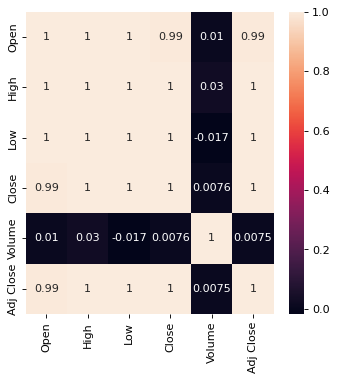

In [122]:
# mapa de calor correlaci√≥n
corr = train_tweets[num_cols].corr()
plt.figure(figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.show()

Pues confirmamos que todas las variables son correlacionadas con **Adj Close**, as√≠ que nos quedamos con **Adj Close**.

In [123]:
train_tweets = train_tweets[['Date', 'Adj Close', 'Volume', 'sentiment', 'Target']]
train_tweets

Date     Adj Close       Volume sentiment  Target
0     2015-01-05   9993.290039  299610800.0  negativo       1
1     2015-01-06   9871.089844  282855400.0  negativo       0
2     2015-01-07   9891.390625  290122400.0   neutral       0
3     2015-01-08  10114.990234  320452300.0   neutral       0
4     2015-01-09   9718.990234  789490200.0   neutral       1
...          ...           ...          ...       ...     ...
1018  2019-05-24   9174.599609  121673100.0  negativo       0
1019  2019-05-27   9216.400391   60178000.0  negativo       0
1020  2019-05-28   9191.799805  218900800.0  negativo       0
1021  2019-05-29   9080.500000  148987100.0  negativo       0
1022  2019-05-30   9157.799805  101389200.0  negativo       0

[1022 rows x 5 columns]

In [124]:
test_tweets = test_tweets[['test_index','Date', 'Adj Close', 'Volume', 'sentiment']]

Pues con estos datos ya podemos hacer nuestro modelo predictivo, primero vamos a prepocesar los datos para que nuestro modelo pueda entrenar con la menor cantidad de ruido posible.

## Preprocesamiento

In [125]:
# convertir sentiment a dummies
train_tweets = pd.get_dummies(train_tweets, columns=['sentiment'])
train_tweets

Date     Adj Close       Volume  Target  sentiment_negativo  \
0     2015-01-05   9993.290039  299610800.0       1                   1   
1     2015-01-06   9871.089844  282855400.0       0                   1   
2     2015-01-07   9891.390625  290122400.0       0                   0   
3     2015-01-08  10114.990234  320452300.0       0                   0   
4     2015-01-09   9718.990234  789490200.0       1                   0   
...          ...           ...          ...     ...                 ...   
1018  2019-05-24   9174.599609  121673100.0       0                   1   
1019  2019-05-27   9216.400391   60178000.0       0                   1   
1020  2019-05-28   9191.799805  218900800.0       0                   1   
1021  2019-05-29   9080.500000  148987100.0       0                   1   
1022  2019-05-30   9157.799805  101389200.0       0                   1   

      sentiment_neutral  sentiment_positivo  
0                     0                   0  
1                     0                   0  
2                     1                   0  
3                     1                   0  
4                     1                   0  
...                 ...                 ...  
1018                  0                   0  
1019                  0                   0  
1020                  0                   0  
1021                  0                   0  
1022                  0                   0  

[1022 rows x 7 columns]

In [126]:
test_tweets = pd.get_dummies(test_tweets, columns=['sentiment'])
test_tweets

test_index        Date    Adj Close       Volume  sentiment_negativo  \
0          6557  2019-06-05  9150.500000  158753000.0                   1   
1          6558  2019-06-06  9169.200195  212720900.0                   1   
2          6559  2019-06-07  9236.099609  150664700.0                   1   
3          6560  2019-06-10  9294.099609  102323700.0                   1   
4          6561  2019-06-11  9282.099609  144701200.0                   1   
..          ...         ...          ...          ...                 ...   
697        7276  2022-03-23  8328.400391  184043600.0                   0   
698        7278  2022-03-25  8330.599609  156189000.0                   0   
699        7279  2022-03-28  8365.599609  167961800.0                   0   
700        7281  2022-03-30  8550.599609  185389000.0                   1   
701        7282  2022-03-31  8445.099609  220117500.0                   0   

     sentiment_neutral  sentiment_positivo  
0                    0                   0  
1                    0                   0  
2                    0                   0  
3                    0                   0  
4                    0                   0  
..                 ...                 ...  
697                  1                   0  
698                  1                   0  
699                  1                   0  
700                  0                   0  
701                  1                   0  

[702 rows x 7 columns]

In [127]:
# estandarizaci√≥n de las variables n√∫mericas
num_cols = ['Volume', 'Adj Close']
# aplicar standarScaler a las variables n√∫mericas
scaler = StandardScaler()
train_tweets[num_cols] = scaler.fit_transform(train_tweets[num_cols])

train_tweets

Date  Adj Close    Volume  Target  sentiment_negativo  \
0     2015-01-05   0.316969  0.722081       1                   1   
1     2015-01-06   0.173228  0.545958       0                   1   
2     2015-01-07   0.197108  0.622344       0                   0   
3     2015-01-08   0.460121  0.941154       0                   0   
4     2015-01-09  -0.005682  5.871398       1                   0   
...          ...        ...       ...     ...                 ...   
1018  2019-05-24  -0.646033 -1.148293       0                   1   
1019  2019-05-27  -0.596864 -1.794693       0                   1   
1020  2019-05-28  -0.625801 -0.126294       0                   1   
1021  2019-05-29  -0.756719 -0.861185       0                   1   
1022  2019-05-30  -0.665794 -1.361506       0                   1   

      sentiment_neutral  sentiment_positivo  
0                     0                   0  
1                     0                   0  
2                     1                   0  
3                     1                   0  
4                     1                   0  
...                 ...                 ...  
1018                  0                   0  
1019                  0                   0  
1020                  0                   0  
1021                  0                   0  
1022                  0                   0  

[1022 rows x 7 columns]

In [128]:
test_tweets[num_cols] = scaler.transform(test_tweets[num_cols])
prep_test = test_tweets.copy()
prep_test = prep_test.drop(['test_index'], axis=1)
prep_test = prep_test.set_index('Date')

In [129]:
X = train_tweets.drop(['Target'], axis=1).set_index('Date')
y = train_tweets['Target']

## Modelizaci√≥n

Para la modelizaci√≥n de nuestro problema nos valdremos de los modelos supervisados de regresi√≥n y clasificaci√≥n, los m√°s populares son Random Forest y Gradient Boosting.

### Random Forest Classifier

Random Forest o tambi√©n conocidos en castellano como '"Bosques Aleatorios"' es una combinaci√≥n de √°rboles predictores tal que cada √°rbol depende de los valores de un vector aleatorio probado independientemente y con la misma distribuci√≥n para cada uno de estos. Es una modificaci√≥n sustancial de bagging que construye una larga colecci√≥n de √°rboles no correlacionados y luego los promedia.

El algoritmo para inducir un random forest fue desarrollado por Leo Breiman y Adele Cutler y Random forests es su marca de f√°brica. El t√©rmino aparece de la primera propuesta de Random decision forests, hecha por Tin Kam Ho de Bell Labs en 1995. El m√©todo combina la idea de bagging de Breiman y la selecci√≥n aleatoria de atributos, introducida independientemente por Ho, Amit y Geman, para construir una colecci√≥n de √°rboles de decisi√≥n con variaci√≥n controlada.

La selecci√≥n de un subconjunto aleatorio de atributos es un ejemplo del m√©todo random subspace, el que, seg√∫n la formulaci√≥n de Ho, es una manera de llevar a cabo la discriminaci√≥n estoc√°stica‚Äã propuesta por Eugenio Kleinberg.

En muchos problemas el rendimiento del algoritmo random forest es muy similar a la del boosting, y es m√°s simple de entrenar y ajustar. Como consecuencia, el Random forest es popular y ampliamente utilizado.

In [130]:
# Grid de hiperpar√°metros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_depth'   : [None, 3, 10, 20],
              'criterion'   : ['gini', 'entropy']
             }

# B√∫squeda por grid search con validaci√≥n cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X, y = y)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

param_criterion param_max_depth param_n_estimators  mean_test_score  \
5         entropy               3                150         0.574043   
1            gini               3                150         0.573059   
3            gini              20                150         0.557741   
2            gini              10                150         0.555469   
6         entropy              10                150         0.555144   

   std_test_score  mean_train_score  std_train_score  
5        0.018286          0.637475         0.006814  
1        0.017311          0.640165         0.005038  
3        0.036667          1.000000         0.000000  
2        0.034710          0.958823         0.004583  
6        0.038642          0.938112         0.007488

In [131]:
# Mejores hiperpar√°metros por validaci√≥n cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperpar√°metros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperpar√°metros encontrados (cv)
----------------------------------------
{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 150} : 0.5740427227801689 accuracy


In [132]:
random_forest = grid.best_estimator_

### Gradient Boosting Classifier

Gradient Boosting, que est√° formado por un conjunto de √°rboles de decisi√≥n individuales, entrenados de forma secuencial, de forma que cada nuevo √°rbol trata de mejorar los errores de los √°rboles anteriores. La predicci√≥n de una nueva observaci√≥n se obtiene agregando las predicciones de todos los √°rboles individuales que forman el modelo.

Muchos m√©todos predictivos generan modelos globales en los que una √∫nica ecuaci√≥n se aplica a todo el espacio muestral. Cuando el caso de uso implica m√∫ltiples predictores, que interaccionan entre ellos de forma compleja y no lineal, es muy dif√≠cil encontrar un √∫nico modelo global que sea capaz de reflejar la relaci√≥n entre las variables. Los m√©todos estad√≠sticos y de machine learning basados en √°rboles engloban a un conjunto de t√©cnicas supervisadas no param√©tricas que consiguen segmentar el espacio de los predictores en regiones simples, dentro de las cuales es m√°s sencillo manejar las interacciones. Es esta caracter√≠stica la que les proporciona gran parte de su potencial.

Los m√©todos basados en √°rboles se han convertido en uno de los referentes dentro del √°mbito predictivo debido a los buenos resultados que generan en problemas muy diversos. A lo largo de este documento se explora la forma en que se construyen y predicen los modelos Gradient Boosting Trees. Dado que el elemento fundamental de un modelo Gradient Boosting Trees son los √°rboles de decisi√≥n, es fundamental entender c√≥mo funcionan estos √∫ltimos.

In [133]:
# Grid de hiperpar√°metros evaluados
# ==============================================================================
param_grid = {'n_estimators'  : [50, 100, 500, 1000],
              'max_features'  : ['auto', 'sqrt', 'log2'],
              'max_depth'     : [None, 1, 3, 5, 10, 20],
              'subsample'     : [0.5, 1],
              'learning_rate' : [0.001, 0.01, 0.1]
             }

# B√∫squeda por grid search con validaci√≥n cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = GradientBoostingClassifier(random_state=123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X, y = y)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

param_learning_rate param_max_depth param_max_features param_n_estimators  \
393                 0.1              10               sqrt                 50   
401                 0.1              10               log2                 50   
381                 0.1               5               log2                500   
373                 0.1               5               sqrt                500   
215                0.01               3               log2               1000   

    param_subsample  mean_test_score  std_test_score  mean_train_score  \
393               1         0.579265        0.006343           1.00000   
401               1         0.579265        0.006343           1.00000   
381               1         0.579257        0.003593           1.00000   
373               1         0.579257        0.003593           1.00000   
215               1         0.578262        0.012610           0.79599   

     std_train_score  
393         0.000000  
401         0.000000  
381         0.000000  
373         0.000000  
215         0.008613

In [134]:
# Mejores hiperpar√°metros por validaci√≥n cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperpar√°metros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperpar√°metros encontrados (cv)
----------------------------------------
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50, 'subsample': 1} : 0.5792651371398999 accuracy


In [135]:
gradient_boosting = grid.best_estimator_

Vemos que los modelos resultan tener un *accuracy* muy parecido alrededor del 57%, por lo que no resulta ser muy confiable, veamos en cuanto le aporta los tweets a nuestro modelo con mayor *accuracy*

In [154]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X.columns,
                             'importancia': gradient_boosting.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
1              Volume     0.486193
0           Adj Close     0.482502
2  sentiment_negativo     0.013338
3   sentiment_neutral     0.009969
4  sentiment_positivo     0.007998

In [ ]:
importancia = permutation_importance(
                estimator    = gradient_boosting,
                X            = X,
                y            = y,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviaci√≥n) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X.columns
df_importancia.sort_values('importances_mean', ascending=False)

Al final parece ser que nuestra variable sentimiento no aporta mucho valor a nuestro modelo, pero es interesante ver que de los 3 sentimientos, el que m√°s aporta es el sentimiento negativo, habr√≠a que recabar m√°s datos, midiendo el volumen de los tweets, a ver si realmente pueden llegar a cambiar la tendencia del indicador.